# Predator Prey model


The predator prey model is a system of coupled differential equations governing how the populations of 2 species (predator and prey) vary with time. The differential equations are given by: <br><br>

$\dfrac{dx}{dt}= a.x - b.x.y$<br><br>
$\dfrac{dy}{dt}= -c.y+ d.x.y$<br><br>

Where:<br>
$x$ = prey population<br>
$y$ = predator population<br>
$t$ = time <br>
$a$ = growth rate of prey in absence of predators <br>
$b$ = death rate of prey due to predators <br> 
$c$ = death rate of predators in absence of prey <br> 
$d$ = growth rate of predators by consuming prey <br><br>

Note that $a$,$b$,$c$,$d$ are all positive constants


We are also provided the initial predator and prey population as follows: <br>
$pdi$ = initial predator population<br>
$pyi$ = initial prey population<br>

The solution to this differential equation is not separable and cannot be directly expressed in terms of $t$:<br><br>

$a.\ln{y} - b.y + c.\ln{x} - d.x = a.\ln{pdi} - b.{pdi} + c.\ln{pyi} - d.{pyi}$<br><br>

We are generating data by providing ranges of values to sample the variables from. The generating function works by generating a specified number of samples for a given value of $a$, $b$, $c$, $d$, $pyi$ and $pdi$. Once these points have been generated, they are passed to an ODE solver (including time) to generate the predator and the prey population. 

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
import numpy as np 
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow.keras.backend as k 
import pylab as p
from scipy import integrate
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
def dX_dt(X,t,a,b,c,d):
    return np.array([a*X[0] - b*X[0]*X[1], -c*X[1] + d*X[0]*X[1]])

In [ ]:
"""
This function is used to generate data for the predator prey model 
The default values specified for the ranges have been chosen such that there won't be a exponential growth in the prey population which can skew results of mse 
min_val and max_val are used to specify ranges for each variable 
mode is used to specify whether linspace or np.random.uniform must be used to sample the data points in the range (time is always sampled with linspace to pass to the DE solver)
const_val is used to specify if all data points generated for that value must  be constant (it takes min_val as the constant value)
num_time_samples specifies how many data points must be drawn per system to be passed to the ODE solver 
num_systems specifies how many different predator prey systems (different growth rate, death rate, initial conditions, etc) must be drawn 
The total number of training examples will be num_time_samples*num_systems

Note: There are some systems for which the ODE solver ends up buggy and doesn't give appropriate results 
The data point corresponding to these systems is regenerated (np.random.uniform) in order to make sure that the results are successful 
However, this does incur an overhead which is not insignificant (about 10% worst case)
It was attempted to tweak the ranges to avoid this issue, but it didn't solve the problem as there were always some critical cases where the solver failed 
So this is the only working approach at present and it takes about 4 mins to generate all the data
"""

def genData(min_a=0.05,max_a=2,min_b=0.05,max_b=2,min_c=0.05,max_c=2,min_d=0.05,max_d=2,min_t=0.01,max_t=50,min_pyi=1,max_pyi=10,min_pdi=1,max_pdi=10,mode='random', const_a=False, const_b=False, const_c=False,const_d=False, const_pyi=False, const_pdi=False, const_t=False, num_time_samples=200,num_systems=10000):
  global count 
  X=[]
  predator=[]
  prey=[]

  if (mode=='random'):
    if const_a:
      a=np.repeat(min_a,num_systems)
    else: 
      a=np.random.uniform(min_a,max_a,size=num_systems)
    if const_b:
      b=np.repeat(min_b,num_systems)
    else: 
      b=np.random.uniform(min_b,max_b,size=num_systems)
    if const_c:
      c=np.repeat(min_c,num_systems)
    else: 
      c=np.random.uniform(min_c,max_c,size=num_systems)
    if const_d:
      d=np.repeat(min_d,num_systems)
    else: 
      d=np.random.uniform(min_d,max_d,size=num_systems)
    if const_pdi:
      pdi=np.repeat(min_pdi,num_systems)
    else: 
      pdi=np.random.uniform(min_pdi,max_pdi,size=num_systems)
    if const_pyi:
      pyi=np.repeat(min_pyi,num_systems)
    else: 
      pyi=np.random.uniform(min_pyi,max_pyi,size=num_systems)
    
    for i in range(num_systems):
      if const_t: 
        t=np.repeat(min_t,num_time_samples)
      else: 
        t=np.linspace(min_t,max_t,num_time_samples)

      X0=np.array ([pyi[i],pdi[i]])
      X_temp,infodict=integrate.odeint(dX_dt,X0,t,full_output=True, args=(a[i],b[i],c[i],d[i]))
      prey_temp,predator_temp=X_temp.T
      s1=np.sum(predator_temp<0.0)+np.sum(prey_temp<0.0)
      while (infodict['message']!='Integration successful.' or s1>0):
        print (i,'retrying') 
        a[i]=np.random.uniform(min_a,max_a,size=1)[0]
        b[i]=np.random.uniform(min_b,max_b,size=1)[0]
        c[i]=np.random.uniform(min_c,max_c,size=1)[0]
        d[i]=np.random.uniform(min_d,max_d,size=1)[0]
        pyi[i]=np.random.uniform(min_pyi,max_pyi,size=1)[0]
        pdi[i]=np.random.uniform(min_pdi,max_pdi,size=1)[0]        
        X_temp,infodict=integrate.odeint(dX_dt,X0,t,full_output=True, args=(a[i],b[i],c[i],d[i]))
        prey_temp,predator_temp=X_temp.T
        s1=np.sum(predator_temp<0.0)+np.sum(prey_temp<0.0)
        count+=1
      
      ax=np.repeat(a[i],num_time_samples)
      bx=np.repeat(b[i],num_time_samples)
      cx=np.repeat(b[i],num_time_samples)
      dx=np.repeat(d[i],num_time_samples)
      pyix=np.repeat(pyi[i],num_time_samples)
      pdix=np.repeat(pdi[i],num_time_samples)
      
      for j in range (num_time_samples):
        x_temp=np.array([ax[j],bx[j],cx[j],dx[j],pyix[j],pdix[j],t[j]])
        cos_x=np.cos(x_temp)
        sin_x=np.sin(x_temp)
        ln_x=np.log(x_temp)
        tanh_x=np.tanh(x_temp)
        x_inv=1/x_temp
        sqrt_x=np.sqrt(x_temp)
        e_minusx=np.exp(-x_temp)
        x_app=np.concatenate((x_temp,cos_x,sin_x,ln_x,tanh_x,x_inv,sqrt_x,e_minusx),axis=0)

        X.append(x_app)
        predator.append(predator_temp[j])
        prey.append(prey_temp[j])


  else: 
    if const_a:
      a=np.repeat(min_a,num_systems)
    else: 
      a=np.linspace(min_a,max_a,num=num_systems)
    if const_b:
      b=np.repeat(min_b,num_systems)
    else: 
      b=np.linspace(min_b,max_b,num=num_systems)
    if const_c:
      c=np.repeat(min_c,num_systems)
    else: 
      c=np.linspace(min_c,max_c,num=num_systems)
    if const_d:
      d=np.repeat(min_d,num_systems)
    else: 
      d=np.linspace(min_d,max_d,num=num_systems)
    if const_pdi:
      pdi=np.repeat(min_pdi,num_systems)
    else: 
      pdi=np.linspace(min_pdi,max_pdi,num=num_systems)
    if const_pyi:
      pyi=np.repeat(min_pyi,num_systems)
    else: 
      pyi=np.linspace(min_pyi,max_pyi,num=num_systems)
    
    for i in range(num_systems):
      if const_t: 
        t=np.repeat(min_t,num_time_samples)
      else: 
        t=np.linspace(min_t,max_t,num_time_samples)

      X0=np.array ([pyi[i],pdi[i]])
      X_temp,infodict=integrate.odeint(dX_dt,X0,t,full_output=True, args=(a[i],b[i],c[i],d[i]))
      while (infodict['message']!='Integration successful.'):
        a[i]=np.random.uniform(min_a,max_a,size=1)[0]
        b[i]=np.random.uniform(min_b,max_b,size=1)[0]
        c[i]=np.random.uniform(min_c,max_c,size=1)[0]
        d[i]=np.random.uniform(min_d,max_d,size=1)[0]
        pyi[i]=np.random.uniform(min_pyi,max_pyi,size=1)[0]
        pdi[i]=np.random.uniform(min_pdi,max_pdi,size=1)[0]        
        X_temp,infodict=integrate.odeint(dX_dt,X0,t,full_output=True, args=(a[i],b[i],c[i],d[i]))

      prey_temp,predator_temp=X_temp.T
      ax=np.repeat(a[i],num_time_samples)
      bx=np.repeat(b[i],num_time_samples)
      cx=np.repeat(b[i],num_time_samples)
      dx=np.repeat(d[i],num_time_samples)
      pyix=np.repeat(pyi[i],num_time_samples)
      pdix=np.repeat(pdi[i],num_time_samples)

      for j in range (num_time_samples):
        x_temp=np.array([ax[j],bx[j],cx[j],dx[j],pyix[j],pdix[j],t[j]])
        cos_x=np.cos(x_temp)
        sin_x=np.sin(x_temp)
        ln_x=np.log(x_temp)
        tanh_x=np.tanh(x_temp)
        x_inv=1/x_temp
        sqrt_x=np.sqrt(x_temp)
        e_minusx=np.exp(-x_temp)
        x_app=np.concatenate((x_temp,cos_x,sin_x,ln_x,tanh_x,x_inv,sqrt_x,e_minusx),axis=0)

        X.append(x_app)
        predator.append(predator_temp[j])
        prey.append(prey_temp[j])

      
  return np.array(X), np.array(predator),np.array(prey)

#Training and test data loading and preprocessing

Data is generated using the genData function and is stored in a csv file before hand. This is because generating the data takes up a lot of memory and time, because several 1000 differential equations are solved every single time by the data generator.

In [ ]:
X,predator,prey=genData()

In [ ]:
df_x=pd.read_csv('drive/My Drive/predator_prey/input1.csv',header=0,index_col=0)
df_pred=pd.read_csv('drive/My Drive/predator_prey/predator1.csv',header=0,index_col=0)
df_prey=pd.read_csv('drive/My Drive/predator_prey/prey1.csv',header=0,index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
print (df_x.head())
print (df_pred.head())
print (df_prey.head())

          0         1         2  ...        53       54        55
0  1.426986  1.339166  1.339166  ...  0.234928  0.00392  0.990050
1  1.426986  1.339166  1.339166  ...  0.234928  0.00392  0.770122
2  1.426986  1.339166  1.339166  ...  0.234928  0.00392  0.599049
3  1.426986  1.339166  1.339166  ...  0.234928  0.00392  0.465977
4  1.426986  1.339166  1.339166  ...  0.234928  0.00392  0.362466

[5 rows x 56 columns]
          0
0  5.541768
1  5.584268
2  5.176612
3  4.714922
4  4.276795
          0
0  1.448477
1  0.311183
2  0.072581
3  0.019679
4  0.006212


In [ ]:
X=df_x.to_numpy()
pred=df_pred.to_numpy()
prey=df_prey.to_numpy()
print (X.shape)
print (pred.shape)
print (prey.shape)
print(X)


(2000000, 56)
(2000000, 1)
(2000000, 1)
[[1.42698562e+00 1.33916618e+00 1.33916618e+00 ... 2.34927877e-01
  3.91958931e-03 9.90049834e-01]
 [1.42698562e+00 1.33916618e+00 1.33916618e+00 ... 2.34927877e-01
  3.91958931e-03 7.70122235e-01]
 [1.42698562e+00 1.33916618e+00 1.33916618e+00 ... 2.34927877e-01
  3.91958931e-03 5.99048893e-01]
 ...
 [2.56432526e-01 3.71735554e-01 3.71735554e-01 ... 1.57831682e-03
  4.11502813e-03 3.18765044e-22]
 [2.56432526e-01 3.71735554e-01 3.71735554e-01 ... 1.57831682e-03
  4.11502813e-03 2.47955244e-22]
 [2.56432526e-01 3.71735554e-01 3.71735554e-01 ... 1.57831682e-03
  4.11502813e-03 1.92874985e-22]]


We add in all the functions associated with the data

In [ ]:
cos_pred=np.cos(pred)
sin_pred=np.sin(pred)
ln_pred=np.log(pred)
tanh_pred=np.tanh(pred)
pred_inv=1/pred
sqrt_pred=np.sqrt(pred)
e_minuspred=np.exp(-pred)

fn_pred=np.concatenate((pred,cos_pred,sin_pred,ln_pred,tanh_pred,pred_inv,sqrt_pred,e_minuspred),axis=1)
print(fn_pred.shape)
X_prey_train=np.concatenate((X,fn_pred),axis=1)
X_prey_train.shape

(2000000, 8)


(2000000, 64)

In [ ]:
cos_prey=np.cos(prey)
sin_prey=np.sin(prey)
ln_prey=np.log(prey)
tanh_prey=np.tanh(prey)
prey_inv=1/prey
sqrt_prey=np.sqrt(prey)
e_minusprey=np.exp(-prey)

fn_prey=np.concatenate((prey,cos_prey,sin_prey,ln_prey,tanh_prey,prey_inv,sqrt_prey,e_minusprey),axis=1)
print(fn_prey.shape)
X_pred_train=np.concatenate((X,fn_prey),axis=1)
X_pred_train.shape

(2000000, 8)


(2000000, 64)

This is test data

In [ ]:
Xtest,predtest,preytest=genData(min_a=1.5,min_b=0.5,min_c=0.75,min_d=0.1,min_pdi=5,min_pyi=5,const_a=True,const_b=True,const_c=True,const_d=True,const_pyi=True,const_pdi=True,num_systems=1)

In [ ]:
preytest=preytest.reshape((len(preytest),1))
cos_prey=np.cos(preytest)
sin_prey=np.sin(preytest)
ln_prey=np.log(preytest)
tanh_prey=np.tanh(preytest)
prey_inv=1/preytest
sqrt_prey=np.sqrt(preytest)
e_minusprey=np.exp(-preytest)

fn_prey=np.concatenate((preytest,cos_prey,sin_prey,ln_prey,tanh_prey,prey_inv,sqrt_prey,e_minusprey),axis=1)
print (fn_prey.shape)
X_pred_test=np.concatenate((Xtest,fn_prey),axis=1)
X_pred_test.shape

(200, 8)


(200, 64)

In [ ]:
predtest=predtest.reshape((len(predtest),1))
cos_pred=np.cos(predtest)
sin_pred=np.sin(predtest)
ln_pred=np.log(predtest)
tanh_pred=np.tanh(predtest)
pred_inv=1/predtest
sqrt_pred=np.sqrt(predtest)
e_minuspred=np.exp(-predtest)

fn_pred=np.concatenate((predtest,cos_pred,sin_pred,ln_pred,tanh_pred,pred_inv,sqrt_pred,e_minuspred),axis=1)
print (fn_pred.shape)
X_prey_test=np.concatenate((Xtest,fn_pred),axis=1)
X_prey_test.shape

(200, 8)


(200, 64)

#LSTM traing and test data pre processing

We scale and reshape both the training and the test data here in order to feed into the LSTM model and train the model

In [ ]:
scaler=MinMaxScaler()

X_pred_train= scaler.fit_transform(X_pred_train)
X_prey_train=scaler.fit_transform(X_prey_train)
print (X_pred_train)
print(X_pred_train.shape)
pred=scaler.fit_transform(pred)
prey=scaler.fit_transform(prey)

[[7.06173777e-01 6.61164486e-01 6.61164486e-01 ... 3.23309690e-13
  6.58684374e-02 2.34927877e-01]
 [7.06173777e-01 6.61164486e-01 6.61164486e-01 ... 1.51007093e-12
  3.05301854e-02 7.32579597e-01]
 [7.06173777e-01 6.61164486e-01 6.61164486e-01 ... 6.47893552e-12
  1.47445322e-02 9.29990794e-01]
 ...
 [1.05844037e-01 1.64982435e-01 1.64982435e-01 ... 3.95561179e-11
  5.96779434e-03 9.88180201e-01]
 [1.05844037e-01 1.64982435e-01 1.64982435e-01 ... 3.70886085e-11
  6.16311089e-03 9.87398833e-01]
 [1.05844037e-01 1.64982435e-01 1.64982435e-01 ... 3.47749416e-11
  6.36482668e-03 9.86566134e-01]]
(2000000, 64)


In [ ]:
Xpred_train=[]
for i in range (10000):
  Xpred_train.append(X_pred_train[200*i:200*(i+1),:])

Xpred_train=np.array(Xpred_train)
print (Xpred_train.shape)

(10000, 200, 64)


In [ ]:
Xprey_train=[]
for i in range (10000):
  Xprey_train.append(X_prey_train[200*i:200*(i+1),:])

Xprey_train=np.array(Xprey_train)
print (Xprey_train.shape)

(10000, 200, 64)


In [ ]:
prey_train=[]
for i in range (10000):
  prey_train.append(prey[200*i:200*(i+1),:])

prey_train=np.array(prey_train)
print (prey_train.shape)

(10000, 200, 1)


In [ ]:
pred_train=[]
for i in range (10000):
  pred_train.append(pred[200*i:200*(i+1),:])

pred_train=np.array(pred_train)
print (pred_train.shape)

(10000, 200, 1)


In [ ]:
X_pred_test=scaler.fit_transform(X_pred_test)
X_prey_test=scaler.fit_transform(X_prey_test)
predtest=predtest.reshape((len(predtest),1))
preytest=preytest.reshape((len(preytest),1))
print(predtest.shape)
predtest=scaler.fit_transform(predtest)
preytest=scaler.fit_transform(preytest)
Xpred_test=X_pred_test.reshape((1,200,64))
Xprey_test=X_prey_test.reshape((1,200,64))

(200, 1)


In [ ]:
 model_pred=tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True,input_shape=(200,64),activation='tanh')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True,activation='tanh')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8,activation='tanh')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='sigmoid'))
])

In [ ]:
model_pred.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['mse'],loss='mean_squared_error')
model_pred.fit(Xpred_train,pred_train,verbose=1,epochs=200,batch_size=4096,shuffle=True)

Epoch 1/200
3/3 [==============================] - 7s 389ms/step - loss: 3.1666e-05 - mse: 3.1666e-05
Epoch 2/200
3/3 [==============================] - 1s 426ms/step - loss: 2.8450e-05 - mse: 2.8450e-05
Epoch 3/200
3/3 [==============================] - 1s 402ms/step - loss: 2.2279e-05 - mse: 2.2279e-05
Epoch 4/200
3/3 [==============================] - 1s 414ms/step - loss: 2.0632e-05 - mse: 2.0632e-05
Epoch 5/200
3/3 [==============================] - 1s 425ms/step - loss: 1.4957e-05 - mse: 1.4957e-05
Epoch 6/200
3/3 [==============================] - 1s 402ms/step - loss: 1.3125e-05 - mse: 1.3125e-05
Epoch 7/200
3/3 [==============================] - 1s 419ms/step - loss: 9.4275e-06 - mse: 9.4275e-06
Epoch 8/200
3/3 [==============================] - 1s 399ms/step - loss: 9.2997e-06 - mse: 9.2997e-06
Epoch 9/200
3/3 [==============================] - 1s 389ms/step - loss: 8.0023e-06 - mse: 8.0023e-06
Epoch 10/200
3/3 [==============================] - 1s 420ms/step - loss: 7.3944e-

Text(0.5, 1.0, 'Evolution of fox and rabbit populations')

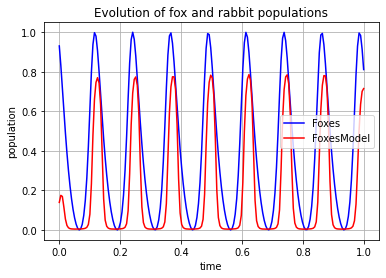

In [ ]:
modelpredtest=model_pred.predict(Xpred_test)
modelpredtest=modelpredtest.reshape((200,1))
rabbits, foxes = preytest,predtest


f1 = p.figure()

p.plot(X_pred_test[:,6], foxes  , 'b-', label='Foxes')
p.plot(X_pred_test[:,6], modelpredtest  , 'r-', label='FoxesModel')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations')

In [ ]:
model_pred.save("drive/My Drive/predator_model_sigmoid_final1.h5")
model_pred.save_weights("drive/My Drive/predator_model_weights_sigmoid_final1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model_pred.load_weights("drive/My Drive/predator_model_weights_sigmoid.h5")

The predator model worked well and learnt a proper function reasonably quick. However, the prey didn't learn the function despite training for a long time. So, the weights were initialized to the trained predator weights. This was done with the expectation that the predator model weights would have captured some relation on the data and it was seen that it had captured the periodicity as well. While it may not have been the same period that the prey model would need, it was thought of as a good starting point for the prey model to learn from. When this was done, the prey model learnt the functions with much greater ease and converged properly

In [ ]:
 model_prey=tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True,input_shape=(200,64),activation='tanh')),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True,activation='tanh')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(8,activation='tanh')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='sigmoid'))
])

In [ ]:
model_prey.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['mse'],loss='mean_squared_error')
model_prey.fit(Xprey_train,prey_train,verbose=1,epochs=300,batch_size=4096,shuffle=True)

Epoch 1/300
3/3 [==============================] - 7s 387ms/step - loss: 1.1880e-05 - mse: 1.1880e-05
Epoch 2/300
3/3 [==============================] - 1s 400ms/step - loss: 1.2966e-05 - mse: 1.2966e-05
Epoch 3/300
3/3 [==============================] - 1s 416ms/step - loss: 1.1177e-05 - mse: 1.1177e-05
Epoch 4/300
3/3 [==============================] - 1s 400ms/step - loss: 1.0442e-05 - mse: 1.0442e-05
Epoch 5/300
3/3 [==============================] - 1s 418ms/step - loss: 9.0960e-06 - mse: 9.0960e-06
Epoch 6/300
3/3 [==============================] - 1s 421ms/step - loss: 9.0897e-06 - mse: 9.0897e-06
Epoch 7/300
3/3 [==============================] - 1s 395ms/step - loss: 8.8667e-06 - mse: 8.8667e-06
Epoch 8/300
3/3 [==============================] - 1s 423ms/step - loss: 9.0067e-06 - mse: 9.0067e-06
Epoch 9/300
3/3 [==============================] - 1s 470ms/step - loss: 8.7572e-06 - mse: 8.7572e-06
Epoch 10/300
3/3 [==============================] - 1s 406ms/step - loss: 8.4917e-

Text(0.5, 1.0, 'Evolution of fox and rabbit populations')

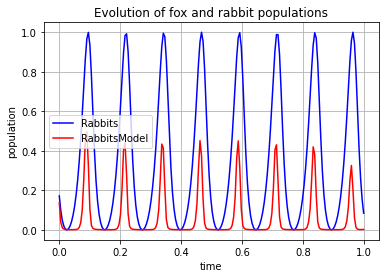

In [ ]:
modelpreytest=model_prey.predict(Xprey_test)
modelpreytest=modelpreytest.reshape((200,1))
rabbits, foxes = preytest,predtest


f1 = p.figure()

p.plot(X_prey_test[:,6], rabbits  , 'b-', label='Rabbits')
p.plot(X_prey_test[:,6], modelpreytest  , 'r-', label='RabbitsModel')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations')

In [ ]:
model_prey.save("drive/My Drive/prey_model_sigmoid_final1.h5")
model_prey.save_weights("drive/My Drive/prey_model_sigmoid_weights_final1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model_prey.load_weights("drive/My Drive/prey_model_sigmoid_weights_final.h5")

Text(0.5, 1.0, 'Evolution of fox and rabbit populations')

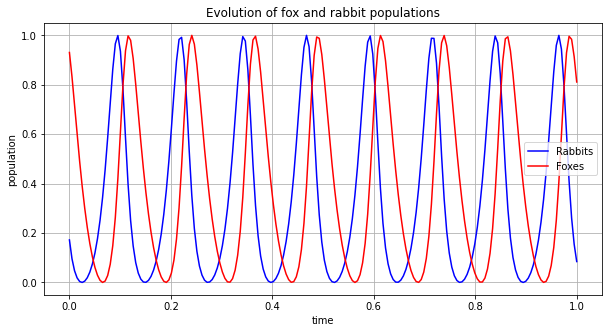

In [ ]:
f1 = p.figure(figsize=(10,5))
rabbits, foxes = preytest,predtest
p.plot(X_prey_test[:,6], rabbits  , 'b-', label='Rabbits')
p.plot(X_prey_test[:,6], foxes  , 'r-', label='Foxes')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations')

Text(0.5, 1.0, 'Evolution of fox and rabbit populations from the model')

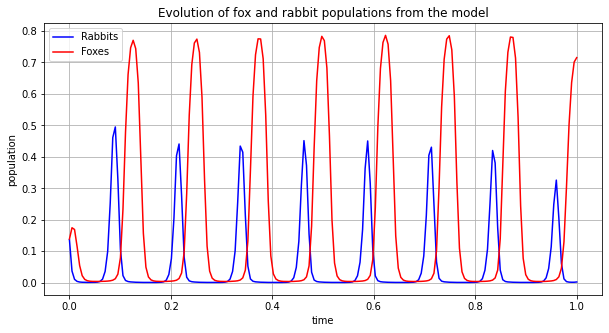

In [ ]:
f1 = p.figure(figsize=(10,5))
rabbits, foxes = preytest,predtest

p.plot(X_prey_test[:,6], modelpreytest  , 'b-', label='Rabbits')
p.plot(X_prey_test[:,6], modelpredtest  , 'r-', label='Foxes')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations from the model')

#Coupling

We initially pre compute the functions of the input variables and store them. The only feature relevant for coupling is the predator / prey population depending on the model that we are using. All the other features can be computed and stored before hand and only the population values need to be computed on the fly. So, the population values can be concatenated with the pre comptued features to be fed into the model at the next time step

In [ ]:
X_pred_test_precomputed=Xpred_test[:,:,:56]
X_prey_test_precomputed=Xprey_test[:,:,:56]
print(X_prey_test_precomputed.shape)
Xpred_test_start=np.expand_dims(np.expand_dims(Xpred_test[0][0],axis=0),axis=0)
Xprey_test_start=np.expand_dims(np.expand_dims(Xprey_test[0][0],axis=0),axis=0)
print (Xpred_test_start.shape)
print (Xprey_test_start.shape)

X_pred_test_temp=Xpred_test_start
X_prey_test_temp=Xprey_test_start

(1, 200, 56)
(1, 1, 64)
(1, 1, 64)


We feed initial conditions to the model and make a prediction on the data. Then we compute the associated functions of the output and concatenate it with the initial conditions. We repeat this process for the other model. After this step we have a model with 2 time steps as the input and we repeat the whole process in a loop. So in each iteration, we re run the model all the way from time step 0, get the predictions, compute the functions of all the outputs from time step 0 to t, and then concatenate them with the pre computed functions. This is important because if we feed in only one time step at a time, we are losing information about the previous time steps and the LSTM won't do very well. 

In [ ]:
X_pred_test_precomputed=Xpred_test[:,:,:56]
X_prey_test_precomputed=Xprey_test[:,:,:56]

Xpred_test_start=np.expand_dims(np.expand_dims(Xpred_test[0][0],axis=0),axis=0)
Xprey_test_start=np.expand_dims(np.expand_dims(Xprey_test[0][0],axis=0),axis=0)

X_pred_test_temp=Xpred_test_start
X_prey_test_temp=Xprey_test_start

for t in range(1,200):
  #scaling
  print (t)
  X_pred_test_temp=scaler.fit_transform(X_pred_test_temp.reshape((X_pred_test_temp.shape[1],64)))
  X_pred_test_temp=np.expand_dims(X_pred_test_temp,axis=0)
  X_prey_test_temp=scaler.fit_transform(X_prey_test_temp.reshape((X_prey_test_temp.shape[1],64)))
  X_prey_test_temp=np.expand_dims(X_prey_test_temp,axis=0)
  #predicting with the model
  modelpredtest_temp=model_pred.predict(X_pred_test_temp)
  modelpredtest_temp=modelpredtest_temp.reshape((modelpredtest_temp.shape[1],1))
  #computing functions for the current predicted predator population 
  cos_pred=np.cos(modelpredtest_temp)
  sin_pred=np.sin(modelpredtest_temp)
  ln_pred=np.log(modelpredtest_temp)
  tanh_pred=np.tanh(modelpredtest_temp)
  pred_inv=1/modelpredtest_temp
  sqrt_pred=np.sqrt(modelpredtest_temp)
  e_minuspred=np.exp(-modelpredtest_temp)
  #concatenating those functions with the current prediction to get a (t,8) shape matrix
  fn_pred=np.concatenate((modelpredtest_temp,cos_pred,sin_pred,ln_pred,tanh_pred,pred_inv,sqrt_pred,e_minuspred),axis=1)
  fn_pred=np.expand_dims(fn_pred,axis=0)
  #concatenating that predator value with the precomputed values for those time steps
 
  Xprey_test_temp=np.concatenate((X_prey_test_precomputed[:,:t,:],fn_pred),axis=2)

  #repeating the above process for prey population
  modelpreytest_temp=model_prey.predict(X_prey_test_temp)
  modelpreytest_temp=modelpreytest_temp.reshape((modelpreytest_temp.shape[1],1))

  cos_prey=np.cos(modelpreytest_temp)
  sin_prey=np.sin(modelpreytest_temp)
  ln_prey=np.log(modelpreytest_temp)
  tanh_prey=np.tanh(modelpreytest_temp)
  prey_inv=1/modelpreytest_temp
  sqrt_prey=np.sqrt(modelpreytest_temp)
  e_minusprey=np.exp(-modelpreytest_temp)

  fn_prey=np.concatenate((modelpreytest_temp,cos_prey,sin_prey,ln_pred,tanh_prey,prey_inv,sqrt_prey,e_minusprey),axis=1)
  fn_prey=np.expand_dims(fn_prey,axis=0)
  Xpred_test_temp=np.concatenate((X_pred_test_precomputed[:,:t,:],fn_prey),axis=2)


  #concatenate the value upto the current time steps with the starting value 
  X_prey_test_temp=np.concatenate((Xprey_test_start,Xprey_test_temp),axis=1)
  X_pred_test_temp=np.concatenate((Xpred_test_start,Xpred_test_temp),axis=1)

In [ ]:
X_prey_test_temp.shape
X_pred_test_temp.shape

(1, 200, 64)

In [ ]:
modelpredtest_temp=model_pred.predict(X_pred_test_temp)
modelpredtest_temp.shape

In [ ]:
modelpreytest_temp=model_prey.predict(X_prey_test_temp)
modelpreytest_temp.shape

(1, 200, 1)

Text(0.5, 1.0, 'Evolution of fox and rabbit populations from the model')

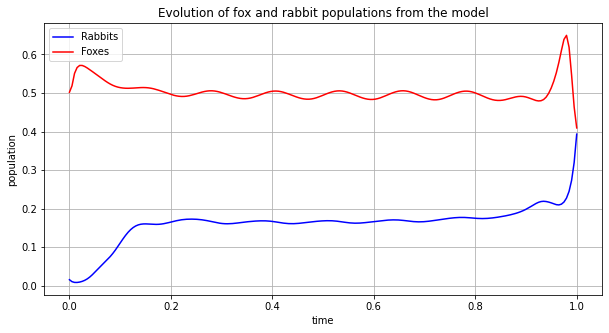

In [ ]:
f1 = p.figure(figsize=(10,5))
rabbits, foxes = preytest,predtest

p.plot(X_prey_test[:,6], modelpreytest_temp[0]  , 'b-', label='Rabbits')
p.plot(X_prey_test[:,6], modelpredtest_temp[0] , 'r-', label='Foxes')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations from the model')

Solving the inverse learning problem for this becomes quite complicated. First the function itself isn't bijective. However, the gradient descent method where we minimize the cost function with respect to the input variables could be a viable method for finding one solution. This would be subject to the random initialization but it can find a solution. But the problem lies in the fact that, unlike an FFNN, the back prop equations for an LSTM aren't simple. They would also involve back prop through time. Which would mean that we would need to keep track of the cell states and such. Additionally we would run into vanishing gradient problems. How we would get around this problem is not very clear at this point. But if we give it just one time step and need it to find inputs corresponding to that single time step, the above method could work but might not work very well

#FFNN (did not work well)

In [ ]:
model_pred=tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=128,input_shape=(64,),activation='tanh'), 
    tf.keras.layers.Dense(units=64,activation='tanh'),
    tf.keras.layers.Dense(units=32,activation='tanh'),
    tf.keras.layers.Dense(units=16,activation='tanh'),
    tf.keras.layers.Dense(units=8,activation='tanh'), 
    tf.keras.layers.Dense(units=4,activation='tanh'),
    tf.keras.layers.Dense(units=2,activation='tanh'), 
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

In [ ]:
model_pred.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['mse'],loss='binary_crossentropy')
model_pred.fit(X_pred_train,pred,verbose=1,epochs=50,batch_size=100000,shuffle=True)

Epoch 1/50
20/20 [==============================] - 1s 25ms/step - loss: 0.0535 - mse: 7.8898e-04
Epoch 2/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0525 - mse: 7.3798e-04
Epoch 3/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0517 - mse: 7.1029e-04
Epoch 4/50
20/20 [==============================] - 0s 21ms/step - loss: 0.0510 - mse: 6.7470e-04
Epoch 5/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0504 - mse: 6.6085e-04
Epoch 6/50
20/20 [==============================] - 0s 21ms/step - loss: 0.0500 - mse: 6.4649e-04
Epoch 7/50
20/20 [==============================] - 0s 21ms/step - loss: 0.0494 - mse: 6.2481e-04
Epoch 8/50
20/20 [==============================] - 0s 21ms/step - loss: 0.0490 - mse: 6.0725e-04
Epoch 9/50
20/20 [==============================] - 0s 21ms/step - loss: 0.0487 - mse: 6.0119e-04
Epoch 10/50
20/20 [==============================] - 0s 22ms/step - loss: 0.0483 - mse: 5.9241e-04
Epoch 11/50
20/20 [

In [ ]:
modelpredtest=model_pred.predict(X_pred_test)


Text(0.5, 1.0, 'Evolution of fox and rabbit populations')

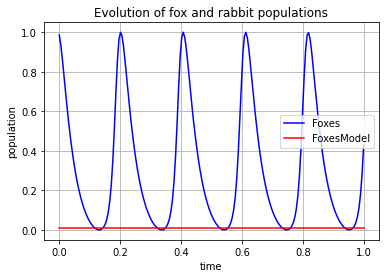

In [ ]:
rabbits, foxes = preytest,predtest


f1 = p.figure()


p.plot(X_pred_test[:,6], foxes  , 'b-', label='Foxes')
p.plot(X_pred_test[:,6], modelpredtest  , 'r-', label='FoxesModel')
p.grid()
p.legend(loc='best')
p.xlabel('time')
p.ylabel('population')
p.title('Evolution of fox and rabbit populations')


#Not working / to be scrapped / debug code 

In [ ]:
X_train_new=[]

for j in range(1,200):

  
  x5=X_train[:,j-1,:]
  x_train_temp=np.concatenate((x5,X_train[:,j,:]),axis=1)
  X_train_new.append(x_train_temp)


print ((X_train_new[0].shape))

(10000, 128)


In [ ]:
X_train_steps=[]
for i in range (len(X_train_new)):
  for j in range (X_train_new[0].shape[0]):
    X_train_steps.append(X_train_new[i][j,:])

print (len(X_train_steps))

1990000


In [ ]:
X_test_new=[]

for j in range(1,200):

  
  x5=X_pred_test[j-1,:]
  x_test_temp=np.concatenate((x5,X_pred_test[j,:]))
  X_test_new.append(x_test_temp)


X_test_new=np.array(X_test_new)
X_test_new.shape

(199, 128)

In [ ]:
X_train_steps[0].shape

(128,)

In [ ]:
X_train_steps=np.array(X_train_steps)

In [ ]:
X_train_steps.shape

(1990000, 128)

In [ ]:
pred_train_steps=pred_train[:,1:,:]
pred_train_steps.shape
pred_train_steps=pred_train_steps.reshape(-1,1)
pred_train_steps.shape

(1990000, 1)

In [ ]:
prey_train_steps=prey_train[:,1:,:]
prey_train_steps.shape

(10000, 199, 1)

In [ ]:
Xtest,predtest,preytest=genData(min_a=1,min_b=0.5,min_c=0.5,min_d=0.075,min_pdi=5,min_pyi=5,const_a=True,const_b=True,const_c=True,const_d=True,const_pyi=True,const_pdi=True,num_systems=1)

In [ ]:
modelpredtest_temp=model_pred.predict(Xpred_test_start)
print (modelpredtest_temp.shape)
modelpredtest_temp=modelpredtest_temp.reshape((modelpredtest_temp.shape[1],1))
modelpredtest_temp.shape

(1, 1, 1)


(1, 1)

In [ ]:
cos_pred=np.cos(modelpredtest_temp)
sin_pred=np.sin(modelpredtest_temp)
ln_pred=np.log(modelpredtest_temp)
tanh_pred=np.tanh(modelpredtest_temp)
pred_inv=1/modelpredtest_temp
sqrt_pred=np.sqrt(modelpredtest_temp)
e_minuspred=np.exp(-modelpredtest_temp)

fn_pred=np.concatenate((modelpredtest_temp,cos_pred,sin_pred,ln_pred,tanh_pred,pred_inv,sqrt_pred,e_minuspred),axis=1)
fn_pred=np.expand_dims(fn_pred,axis=0)
print (fn_pred.shape)
print(Xprey_test_start.shape)

(1, 1, 8)
(1, 1, 64)


array([[0.        , 0.        , 0.        , ..., 0.44559765, 0.25093803,
        0.09934956],
       [0.        , 0.        , 0.        , ..., 0.61190454, 0.14900273,
        0.27650637],
       [0.        , 0.        , 0.        , ..., 0.77041834, 0.07737285,
        0.52924469],
       ...,
       [0.        , 0.        , 0.        , ..., 0.32115871, 0.3572927 ,
        0.03013923],
       [0.        , 0.        , 0.        , ..., 0.47711432, 0.22876986,
        0.12536288],
       [0.        , 0.        , 0.        , ..., 0.64379198, 0.1329859 ,
        0.32131491]])

In [ ]:
np.expand_dims(X_prey_test_precomputed[:,1,:],axis=1).shape

(1, 1, 56)

In [ ]:
Xprey_test_temp=np.concatenate((np.expand_dims(X_prey_test_precomputed[:,1,:],axis=1),fn_pred),axis=2)

In [ ]:
X_prey_test_temp=np.concatenate((Xprey_test_start,Xprey_test_temp),axis=1)

In [ ]:
X_prey_test_temp.shape

(1, 2, 64)

In [ ]:
predtest=predtest.reshape((len(predtest),1))
cos_pred=np.cos(predtest)
sin_pred=np.sin(predtest)
ln_pred=np.log(predtest)
tanh_pred=np.tanh(predtest)
pred_inv=1/predtest
sqrt_pred=np.sqrt(predtest)
e_minuspred=np.exp(-predtest)

fn_pred=np.concatenate((predtest,cos_pred,sin_pred,ln_pred,tanh_pred,pred_inv,sqrt_pred,e_minuspred),axis=1)
print (fn_pred.shape)
X_prey_test=np.concatenate((Xtest,fn_pred),axis=1)
X_prey_test.shape

X_pred_test=scaler.fit_transform(X_pred_test)
X_prey_test=scaler.fit_transform(X_prey_test)
predtest=predtest.reshape((len(predtest),1))
preytest=preytest.reshape((len(preytest),1))
print(predtest.shape)
predtest=scaler.fit_transform(predtest)
preytest=scaler.fit_transform(preytest)
Xpred_test=X_pred_test.reshape((1,200,64))
Xprey_test=X_prey_test.reshape((1,200,64))

(200, 8)
(200, 1)
